In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow.keras import layers
from tensorflow import keras
from helper_functions.scan_helper_functions_configs_MP import *
from helper_functions.MIE_NN.MieTFNew import PINNLossFunctionP11
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
#from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

2022-03-31 18:59:38.592006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/user/ponts_m/pythonenv/lib:
2022-03-31 18:59:38.592054: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-31 18:59:41.037255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/user/ponts_m/pythonenv/lib:
2022-03-31 18:59:41.037306: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 18:59:41.037358: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (merlin-c-105.psi.c

# Looking at the training history

### Reading in the training- and validation data

In [2]:
train_datafile = '/data/user/ponts_m/DataSets/GODataSet/DS10000_532nm_GO_scaled.h5'

dvar_train_wo_scaling, dvar_val_wo_scaling, qoi_train_wo_scaling, qoi_val_wo_scaling = load_dataset_wo_split(train_datafile)

dvar_train = dvar_train_wo_scaling
dvar_val = dvar_val_wo_scaling

qoi_train = qoi_train_wo_scaling
qoi_val = qoi_val_wo_scaling

n_in = dvar_train.shape[1]
n_out = qoi_train.shape[1]

### Model directories for the normal NN and the physics informed NN

In [3]:
model_name_nn = 'forward_model_nn'
model_name_pinn = 'forward_model_pinn'
model_dir = '/data/project/general/aerosolretriev/aerosol_results_mp/TransferLearning/Test/'

### Load both models

In [4]:

custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
    'AdjustedRSquared_custom': AdjustedRSquared_custom,
    'custom_loss': custom_loss_wrapper,
}

kwargs = {
    'custom_objects': custom_objects,
}

final_model_nn = keras.models.load_model(f'{model_dir}/forward_model_nn')
final_model_pinn = keras.models.load_model(f'{model_dir}/forward_model_pinn', custom_objects=custom_objects)

### Load the training history and the metrics which were already calculated and saved after training when running the transfer learning script

In [5]:
with open(f'{model_dir}/nn_history.pkl', 'rb') as a:
    nn_history = pickle.load(a)
        
with open(f'{model_dir}/pinn_history_history.pkl', 'rb') as b:
    pinn_history = pickle.load(b)
        
with open(f'{model_dir}/metrics_train_nn.pkl', 'rb') as c:
    metrics_train_nn = pickle.load(c)
        
with open(f'{model_dir}/metrics_train_pinn.pkl', 'rb') as d:
    metrics_train_pinn = pickle.load(d)
        
with open(f'{model_dir}/metrics_val_nn.pkl', 'rb') as e:
    metrics_val_nn = pickle.load(e)
        
with open(f'{model_dir}/metrics_val_pinn.pkl', 'rb') as f:
    metrics_val_pinn = pickle.load(f)
    
with open(f'{model_dir}/metrics_train_abs_pinn.pkl', 'rb') as g:
    metrics_train_abs_pinn = pickle.load(g)
    
with open(f'{model_dir}/metrics_val_abs_pinn.pkl', 'rb') as h:
    metrics_val_abs_pinn = pickle.load(h)

### Printing the training history keys and reading in the loss and validation loss for plotting below

In [6]:
print(nn_history.history.keys())
loss_nn = nn_history.history['loss']
val_loss_nn = nn_history.history['val_loss']

print(pinn_history.keys())
loss_pinn = pinn_history['loss']
val_loss_pinn = pinn_history['val_loss']

dict_keys(['loss', 'MAE', 'MAPE', 'val_loss', 'val_MAE', 'val_MAPE'])
dict_keys(['loss', 'adjusted_r2', 'val_loss', 'val_adjusted_r2'])


### Plotting the loss and the validation loss versus the epochs for both the normal NN and the physics informed NN

Text(0.5, 1.0, 'pinn')

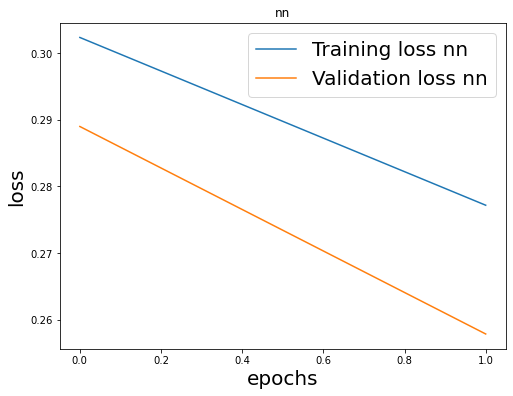

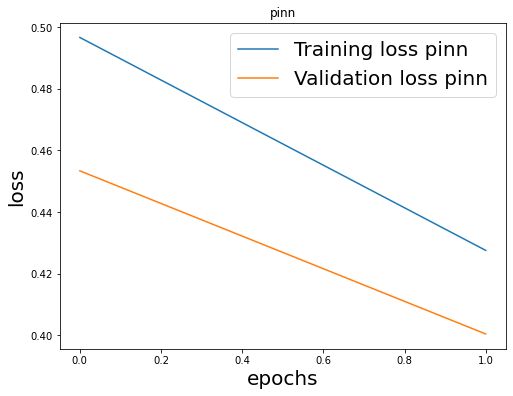

In [7]:
plt.figure(figsize = (8,6))
plt.plot(loss_nn, label = 'Training loss nn')
plt.plot(val_loss_nn, label = 'Validation loss nn')
plt.legend(fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epochs', fontsize = 20)
plt.title('nn')

plt.figure(figsize = (8,6))
plt.plot(loss_pinn, label = 'Training loss pinn')
plt.plot(val_loss_pinn, label = 'Validation loss pinn')
plt.legend(fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epochs', fontsize = 20)
plt.title('pinn')

### Looking at the metrics

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

 $ {\displaystyle {\mbox{WMAPE}}={\frac {\sum _{t=1}^{n}\left|A_{t}-F_{t}\right|}{\sum _{t=1}^{n}\left|A_{t}\right|}}}$

where A is a vector of the actual data and F is the forecast. The advantage of this metric over MAPE is that this overcomes the 'infinite error' issue

In [8]:
print('Training metrics for the normal NN:')
metrics_train_nn

Training metrics for the normal NN:


{'MAE': 673.2981421580346,
 'MAPE': 58.36348724050216,
 'MSE': 1868615.0450666167,
 'median_percentile_max_error': 99.98924847773387,
 '90_percentile_max_error': 141.4324976119603,
 'r2': -2.1280046684038774,
 'r2_adj': -2.2000139842131494,
 'wmape': 88.52666925707055}

In [9]:
print('Validation metrics for the normal NN:')
metrics_val_nn

Validation metrics for the normal NN:


{'MAE': 677.1116583082983,
 'MAPE': 58.27488570199765,
 'MSE': 1900723.060981802,
 'median_percentile_max_error': 99.98907322773192,
 '90_percentile_max_error': 140.70856029346828,
 'r2': -2.102182238572543,
 'r2_adj': -2.4091601401355214,
 'wmape': 88.68180210154756}

In [10]:
print('Training metrics for the normal PINN:')
metrics_train_pinn

Training metrics for the normal PINN:


{'MAE': 525.8822448291152,
 'MAPE': 170.00239328455663,
 'MSE': 1043881.673259621,
 'median_percentile_max_error': 91.92701171124418,
 '90_percentile_max_error': 715.7292705106697,
 'r2': -0.9374839802891776,
 'r2_adj': -0.9820865018970626,
 'wmape': 69.14411408731574}

In [11]:
print('Validation metrics for the normal PINN:')
metrics_val_pinn

Validation metrics for the normal PINN:


{'MAE': 522.6422205555475,
 'MAPE': 151.9625346838005,
 'MSE': 1029682.3781866271,
 'median_percentile_max_error': 91.94950583986304,
 '90_percentile_max_error': 703.5974965518892,
 'r2': -0.9201580148962899,
 'r2_adj': -1.110168153808512,
 'wmape': 68.45082846309104}

### Printing the difference between normal NN metrics and physics informed NN metrics. Positive numbers are 'good' because that means the physics informed NN is winning ;)

In [12]:
print('Normal NN metrics - Physics Informed NN metrics (Training): \n')
for key in metrics_train_nn:
    print(key, metrics_train_nn[key]-metrics_train_pinn[key])

print('\n')
    
print('Normal NN metrics - Physics Informed NN metrics (Validation): \n')
for key in metrics_val_nn:
    print(key, metrics_val_nn[key]-metrics_val_pinn[key])

Normal NN metrics - Physics Informed NN metrics (Training): 

MAE 147.4158973289194
MAPE -111.63890604405447
MSE 824733.3718069957
median_percentile_max_error 8.06223676648969
90_percentile_max_error -574.2967728987094
r2 -1.1905206881146997
r2_adj -1.2179274823160868
wmape 19.38255516975481


Normal NN metrics - Physics Informed NN metrics (Validation): 

MAE 154.46943775275076
MAPE -93.68764898180285
MSE 871040.6827951749
median_percentile_max_error 8.039567387868885
90_percentile_max_error -562.8889362584209
r2 -1.1820242236762533
r2_adj -1.2989919863270094
wmape 20.23097363845652


# Test performances of the new neural networks

### Read in Test Data and Preprocess it

In [13]:
def scaling(data):
    return (data - np.min(data))/(np.max(data)-np.min(data))

def inverse_scaling(data, xmax, xmin):
    return data*(xmax-xmin)+xmin

In [14]:
test_datafile = '/data/user/ponts_m/DataSets/GODataSet/DSTest20000_532nm_GO.h5'

dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
n_in = dvar_test.shape[1]

dvar_max = np.max(dvar_test).to_numpy()
dvar_min = np.min(dvar_test).to_numpy()
qoi_max = np.max(qoi_test).to_numpy()
qoi_min = np.min(qoi_test).to_numpy()

dvar_test_scaled = scaling(dvar_test)
qoi_test_scaled = scaling(qoi_test)

### Predict Test Data and Inverse Preprocess it

In [15]:
qoi_pred_test_nn_scaled = final_model_nn.predict(dvar_test)
qoi_pred_test_pinn_scaled = final_model_pinn.predict(dvar_test)[:,-5:]

In [16]:
qoi_pred_test_nn = inverse_scaling(qoi_pred_test_nn_scaled, qoi_max, qoi_min)
qoi_pred_test_pinn = inverse_scaling(qoi_pred_test_pinn_scaled, qoi_max, qoi_min)

### Calculate Metrics

In [17]:
metrics_test_nn = calculate_metrics_custom(qoi_test, qoi_pred_test_nn, n_in)
metrics_test_pinn = calculate_metrics_custom(qoi_test, qoi_pred_test_pinn, n_in)

### Look at metrics of the normal NN for every aerosol parameter separately

In [20]:
print('Normal NN metrics: \n')
for key in metrics_test_nn:
    print(key,'\n', metrics_test_nn[key], '\n')

Normal NN metrics: 

MAE 
 RealRefractiveIndex            12.148103
ImaginaryRefractiveIndex        0.100219
Sigma                           0.829583
MeanRadius                  19713.924522
VolumeConcentration          2487.284461
dtype: float64 

MAPE 
 RealRefractiveIndex          832.519719
ImaginaryRefractiveIndex      99.983241
Sigma                         58.240016
MeanRadius                  2489.482508
VolumeConcentration           99.827858
dtype: float64 

MSE 
 RealRefractiveIndex         1.515844e+02
ImaginaryRefractiveIndex    1.339544e-02
Sigma                       7.151218e-01
MeanRadius                  4.190728e+08
VolumeConcentration         8.258068e+06
dtype: float64 

wmape 
 RealRefractiveIndex          829.284636
ImaginaryRefractiveIndex      99.997534
Sigma                         58.223531
MeanRadius                  1484.507410
VolumeConcentration           99.958939
dtype: float64 

median_percentile_max_error 
 1414.3236478347285 

90_percentile_max_error

### Look at metrics of the physics informed NN for every aerosol parameter separately

In [21]:
print('Normal NN metrics: \n')
for key in metrics_test_nn:
    print(key,'\n', metrics_test_pinn[key], '\n')

Normal NN metrics: 

MAE 
 RealRefractiveIndex              0.134860
ImaginaryRefractiveIndex         3.468988
Sigma                            0.671889
MeanRadius                    7627.606065
VolumeConcentration         189164.121893
dtype: float64 

MAPE 
 RealRefractiveIndex             8.949601
ImaginaryRefractiveIndex    19756.298447
Sigma                          47.170705
MeanRadius                    700.586406
VolumeConcentration         32360.818376
dtype: float64 

MSE 
 RealRefractiveIndex         2.421906e-02
ImaginaryRefractiveIndex    1.248438e+01
Sigma                       4.677081e-01
MeanRadius                  7.372628e+07
VolumeConcentration         3.625320e+10
dtype: float64 

wmape 
 RealRefractiveIndex            9.206123
ImaginaryRefractiveIndex    3461.336907
Sigma                         47.155942
MeanRadius                   574.377654
VolumeConcentration         7602.123986
dtype: float64 

median_percentile_max_error 
 9915.985171149987 

90_percentile_

### Look at difference of the metrics

In [22]:
print('Normal NN metrics - Physics Informed NN metrics (Testing): \n')
for key in metrics_test_nn:
    print(key,'\n', metrics_test_nn[key]-metrics_test_pinn[key], '\n')

Normal NN metrics - Physics Informed NN metrics (Testing): 

MAE 
 RealRefractiveIndex             12.013243
ImaginaryRefractiveIndex        -3.368770
Sigma                            0.157694
MeanRadius                   12086.318456
VolumeConcentration        -186676.837431
dtype: float64 

MAPE 
 RealRefractiveIndex           823.570118
ImaginaryRefractiveIndex   -19656.315206
Sigma                          11.069311
MeanRadius                   1788.896102
VolumeConcentration        -32260.990518
dtype: float64 

MSE 
 RealRefractiveIndex         1.515602e+02
ImaginaryRefractiveIndex   -1.247099e+01
Sigma                       2.474137e-01
MeanRadius                  3.453465e+08
VolumeConcentration        -3.624494e+10
dtype: float64 

wmape 
 RealRefractiveIndex          820.078512
ImaginaryRefractiveIndex   -3361.339373
Sigma                         11.067589
MeanRadius                   910.129756
VolumeConcentration        -7502.165047
dtype: float64 

median_percentile_max_er